In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
import shap
shap.initjs()
import xgboost as xgb
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.wrappers.scikit_learn import KerasClassifier

# Split Model

In [2]:

df = pd.read_csv('ecom-user-churn-data.csv')
df.drop(['int_cat15_n'], axis= 'columns')

X = df.drop('target_class', axis=1)
y = df['target_class']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and choose model

In [3]:

# for simplicity lets consider only 3 good classification models
models = {
    'Logistic Regression': LogisticRegression(),
    #'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'GBM': GradientBoostingClassifier(),
    #'XBG': xgb.XGBClassifier(objective='binary:logistic')
    #'Neural Network': KerasClassifier(build_fn=lambda: create_nn(X_train_scaled.shape[1]), epochs=100, batch_size=10, verbose=0)
}

# Function to create a neural network model
#def create_nn(feature_dim):
#    model = Sequential()
#    model.add(Dense(12, input_dim=feature_dim, activation='relu'))
#    model.add(Dense(8, activation='relu'))
#    model.add(Dense(1, activation='sigmoid'))
#    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#    return model


In [4]:
# Cross-validation and performance metrics
results = {}
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# here we use normalized data for logistic regression and the common dat for the others

for name, model in models.items():
    if name == 'Logistic Regression':
        cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring='roc_auc')
        print(f'finished cv for {name} AUC: {np.mean(cv_results)}')
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        if hasattr(model, 'predict_proba'):
            y_probs = model.predict_proba(X_test_scaled)[:, 1]
        else:
            y_probs = model.predict(X_test_scaled).ravel()
    else:
        cv_results = cross_val_score(model, X_train, y_train, cv=kf, scoring='roc_auc')
        print(f'finished cv for {name} AUC: {np.mean(cv_results)}')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        if hasattr(model, 'predict_proba'):
            y_probs = model.predict_proba(X_test)[:, 1]
        else:
            y_probs = model.predict(X_test).ravel()
    
    auc = roc_auc_score(y_test, y_probs)
    accuracy = accuracy_score(y_test, np.round(y_probs))
    precision = precision_score(y_test, np.round(y_probs))
    recall = recall_score(y_test, np.round(y_probs))
    f1 = f1_score(y_test, np.round(y_probs))
 # Model Evaluation
    results[name] = {
        'CV AUC': np.mean(cv_results),
        'CV AUC std': np.std(cv_results),
        'AUC': auc,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

# Display results
results_df = pd.DataFrame(results).transpose()
print(results_df)


finished cv for Logistic Regression AUC: 0.7398325368423845
finished cv for Random Forest AUC: 0.7190411076584006
finished cv for GBM AUC: 0.7495347488970527
                       CV AUC  CV AUC std       AUC  Accuracy  Precision  \
Logistic Regression  0.739833    0.004121  0.732392  0.895057   0.899804   
Random Forest        0.719041    0.006455  0.717546  0.895057   0.899475   
GBM                  0.749535    0.005680  0.748540  0.898602   0.900823   

                       Recall  F1 Score  
Logistic Regression  0.992721  0.943982  
Random Forest        0.993176  0.944006  
GBM                  0.995792  0.945930  


# about model evaluation

* AUC: Area under the roc curve curve, it shows us how well our classification model separates the classes ranges from [0,1]
* Accuracy: overall score of the model, measures all the correct predicts against the count of rows
* Precision: number of correct predictions of positives against the total ocurrences predicted as positive
* Recall:  number of correct predictions of positives against the total ocurrences of real positives
* F1: harmonic mean of precision and recall

# improve the best model

Now that we see the GBM is the best model, we can fine tune it to perform even better 

In [5]:
test_options = {'learning_rate':[0.3,0.2,0.1,0.05,0.01],
                'n_estimators':np.arange(50,200,50).tolist(),
                'max_depth':np.arange(2,5,1).tolist()}

tuning = GridSearchCV(estimator = GradientBoostingClassifier(),
    param_grid = test_options,scoring = 'roc_auc',n_jobs = 4, cv = 5)

tuning.fit(X_train, y_train)
tuning.scorer_, tuning.best_params_, tuning.best_score_

(make_scorer(roc_auc_score, needs_threshold=True),
 {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100},
 0.751259164852703)

In [6]:
tuning.scorer_, tuning.best_params_, tuning.best_score_

(make_scorer(roc_auc_score, needs_threshold=True),
 {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100},
 0.751259164852703)

# interpretation

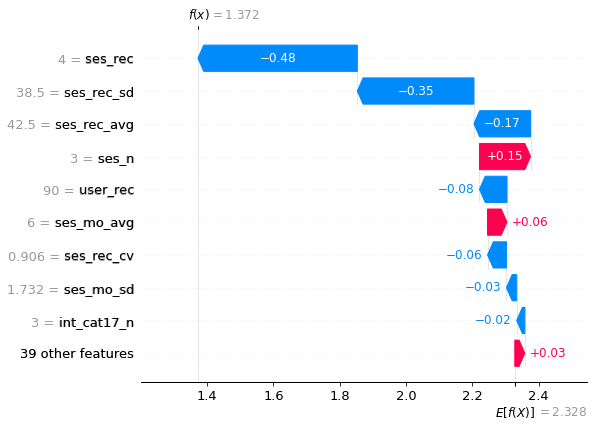

In [23]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

shap.plots.waterfall(shap_values[0])

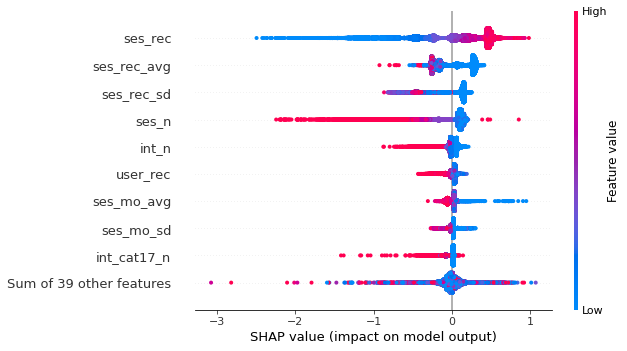

In [24]:
shap.plots.beeswarm(shap_values)